### 1. What are 3 areas in industry where computer vision is currently being used?

I. Defects detection on assembly line <br>
II. Self-driving vehicles <br>
III. Face recognition 

### 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

Overfitting occurs when a machine learning model is trained on the training data repeatedly. Over time the model will perform very well on the training data, but poorly on the test data. 

### 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. Note: there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

I. Hold-out: Splitting the whole dataset to training and testing datasets. <br>
II. Data Augmentation: Creates new data from the available data. <br>
III. Regularization:  This makes the model learn broader patterns rather then memorizing the data.

### 4. Spend 20-minutes reading and clicking through the <a href="https://poloclub.github.io/cnn-explainer/"> CNN Explainer website </a>.
    * Upload your own example image using the "upload" button and see what happens in each layer of a CNN as your image passes through it.

### 5. Load the <a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST">torchvision.datasets.MNIST()</a> train and test datasets.

In [200]:
import numpy as np
import random
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import randrange
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/archian/Development/Projects/Python/Torch/env/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [3]:
train_data = datasets.MNIST(root='data',train=True,download=True,transform=ToTensor())
test_data = datasets.MNIST(root='data',train=False,download=True,transform=ToTensor())

### 6. Visualize at least 5 different samples of the MNIST training dataset.

In [4]:
class_name =  train_data.classes

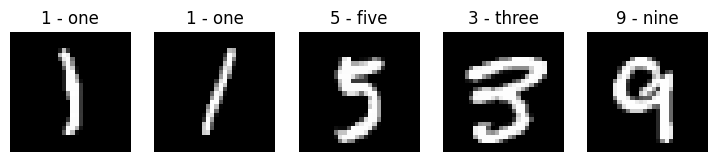

In [5]:
fig = plt.figure(figsize=(9,9))
row,colm = 1,5
for i in range(1,row*colm+1):
    random_index = torch.randint(1,len(train_data),size=[1]).item()
    image,label = train_data[random_index]
    fig.add_subplot(row,colm,i)
    plt.title(class_name[label])
    plt.axis(False)
    plt.imshow(image.squeeze(),cmap="gray")

### 7. Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

In [6]:
train_dataloader =  DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=32)   


### 8. Recreate model_2 used in this notebook (the same model from the <a href='https://poloclub.github.io/cnn-explainer/'>CNN Explainer website</a>, also known as TinyVGG) capable of fitting on the MNIST dataset.

In [7]:
class MNISTModel(nn.Module):
    def __init__(self,input_shape,output_shape,hidden_units):
        super().__init__()
        self.block_1= nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,out_features=output_shape)
        )
        
    def forward(self,x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.linear_layer(x)
        return x

### 9. Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.

In [99]:
model_0 = MNISTModel(input_shape=1,output_shape=len(class_name),hidden_units=10)
next(model_0.parameters()).device

device(type='cpu')

In [100]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [101]:
%%time
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"---Epoch: {epoch}---")
    train_loss_cpu = 0
    for batch,(X_cpu,y_cpu) in enumerate(train_dataloader):
        model_0.train()
        # Forward Pass
        y_pred_cpu = model_0(X_cpu)
        # Calculate the loss
        loss_cpu = loss_fn(y_pred_cpu,y_cpu)
        train_loss_cpu += loss_cpu 
        # Optimizer zero grad
        optimizer.zero_grad()
        # loss backwards
        loss_cpu.backward()
        # Step the optimizer
        optimizer.step()


    train_loss_cpu /= len(train_dataloader)
    # Test the model
    test_loss_cpu = 0
    model_0.eval()
    with torch.inference_mode():
        for batch,(X_test_cpu,y_test_cpu) in enumerate(test_dataloader):
            test_pred_cpu = model_0(X_test_cpu)
            # Calculate the loss
            test_loss_cpu += loss_fn(test_pred_cpu,y_test_cpu) 
                

        test_loss_cpu /= len(test_dataloader)
    print(f"Loss: {train_loss_cpu:.3f} | Test loss: {test_loss_cpu:.3f}")
    

  0%|          | 0/3 [00:00<?, ?it/s]

---Epoch: 0---


 33%|███▎      | 1/3 [01:12<02:24, 72.44s/it]

Loss: 0.281 | Test loss: 0.082
---Epoch: 1---


 67%|██████▋   | 2/3 [02:11<01:04, 64.79s/it]

Loss: 0.067 | Test loss: 0.057
---Epoch: 2---


100%|██████████| 3/3 [03:22<00:00, 67.65s/it]

Loss: 0.053 | Test loss: 0.056
CPU times: user 5min 52s, sys: 1.9 s, total: 5min 53s
Wall time: 3min 22s


In [219]:
### Currently, my nvidia driver is causing an error.
# %%time


# # Model on GPU
# model_0_gpu = MNISTModel(input_shape=1,hidden_units=10,output_shape=10).to(device)


# # Training loop
# epochs = 3
# for epoch in tqdm(range(epochs)):
#   print(f"---Epoch: {epoch}---")
#   train_loss_gpu = 0
#   model_0_gpu.train()
#   for batch, (X_gpu, y_gpu) in enumerate(train_dataloader):
#     # Put data on target device
#     X_gpu, y_gpu = X_gpu.to(device), y_gpu.to(device)

#     # Forward pass
#     y_pred_gpu = model_0_gpu(X_gpu)

#     # Calculate the loss
#     loss_gpu = loss_fn(y_pred_gpu, y_gpu)
#     train_loss_gpu += loss_gpu

#     # Optimizer zero grad
#     optimizer.zero_grad()

#     # Loss backwards
#     loss_gpu.backward()

#     # Step the optimizer
#     optimizer.step()
  
#   train_loss_gpu /= len(train_dataloader)

#   # Test the model
#   test_loss_gpu = 0
#   model_0_gpu.eval()
#   with torch.inference_mode():
#     for X_test_gpu, y_test_gpu in test_dataloader:
#       # Make sure test data on target device
#       X_test_gpu, y_test_gpu = X_test_gpu.to(device), y_test_gpu.to(device)
      
#       test_pred_gpu = model_0_gpu(X_test_gpu)
#       test_loss_gpu += loss_fn(test_pred_gpu, y_test_gpu)

#     # Adjust test loss total for number of batches
#     test_loss_gpu /= len(test_dataloader)
  
#   # Print out what's happening
#   print(f"Loss: {train_loss_gpu:.2f} | Test loss: {test_loss_gpu:.2f}")

### 10.Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

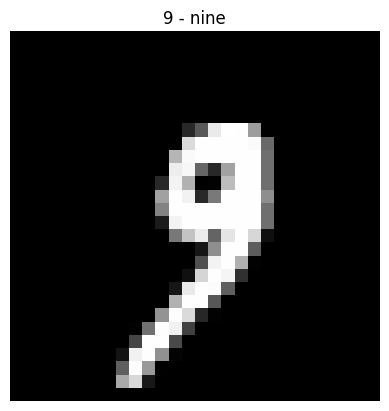

In [212]:
test_image_samples, true_label = test_dataloader.dataset.data,test_dataloader.dataset.targets
plt.imshow(test_image_samples[1000],cmap="gray")
plt.title(class_name[true_label[1000]])
plt.axis(False)
plt.show()

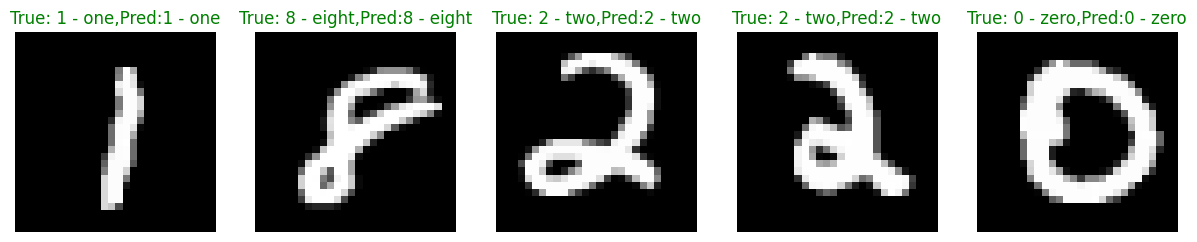

In [217]:
# Sample Test
pred_fig = plt.figure(figsize=(15,15))
rows,colms = 1,5
for i in range(1,rows*colms+1):
    random_index = torch.randint(1,len(test_data),size=[1]).item()
    plot_test_image, plot_test_label = test_data[random_index]
    plot_test_image = plot_test_image.to(device)
    model_0.eval()
    with torch.inference_mode():
        y_logits = model_0(plot_test_image.unsqueeze(0))
        y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
    pred_fig.add_subplot(rows,colms,i)
    if y_pred == plot_test_label:
        plt.title(f"True: {class_name[plot_test_label]},Pred:{class_name[y_pred]}", c="g")
    else:
        plt.title(f"True: {class_name[plot_test_label]},Pred:{class_name[y_pred]}", c="r")
    plt.axis(False)
    plt.imshow(plot_test_image.squeeze().to('cpu'),cmap="gray")

In [105]:
# Whole Test
y_whole_pred = []
model_0.eval()

for X,y in tqdm(test_dataloader,desc="Making prediction on the whole test data"):
    with torch.inference_mode():
        y_logits = model_0(X)
        y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
        y_whole_pred.append(y_pred.cpu())
    
y_whole_pred = torch.cat(y_whole_pred)
y_whole_pred

Making prediction on the whole test data: 100%|██████████| 313/313 [00:05<00:00, 55.35it/s]


tensor([7, 2, 1,  ..., 4, 5, 6])

### 11.Plot a confusion matrix comparing your model's predictions to the truth labels.

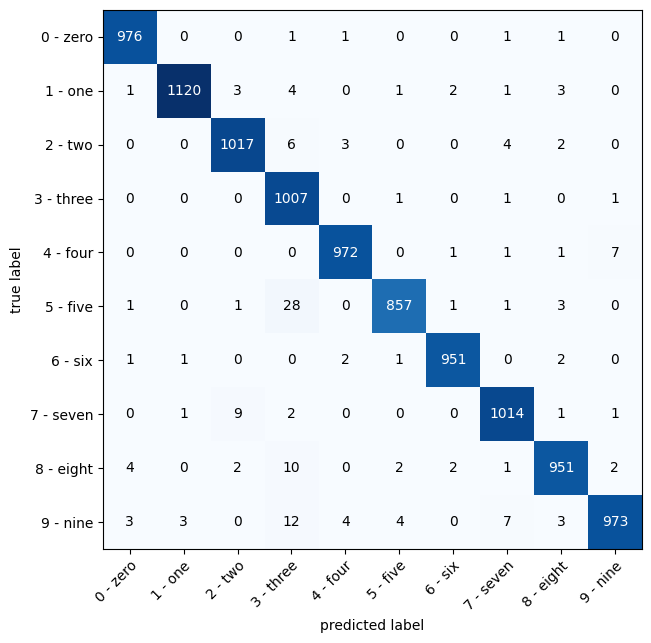

In [106]:
# Making a confusion matrix for further predictions

confmat = ConfusionMatrix(num_classes=len(class_name),task="MULTICLASS")
confmat_tensor = confmat(preds=y_whole_pred,target=true_label)
# print(confmat_tensor)

# # Plot the confusion matrix
fig,ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),class_names=class_name,figsize=(10,7))


### 12. Create a random tensor of shape [1, 3, 64, 64] and pass it through a nn.Conv2d() layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the kernel_size parameter goes up and down?

In [98]:
sample_tensor = torch.randn(size=(1,3,64,64))
# plt.imshow(sample_tensor[0][0])
n = 1
test_model = nn.Conv2d(in_channels=3,kernel_size=n,padding=0,stride=1,out_channels=1)
sample_tensor_result = test_model(sample_tensor)
sample_tensor_result.shape

torch.Size([1, 1, 64, 64])

While the stride is 1 and padding is 0,an increase in the kernel_size will reduce the size of the output by n-1. 

### 13. Use a model similar to the trained model_2 from this notebook to make predictions on the test torchvision.datasets.FashionMNIST dataset.
    * Then plot some predictions where the model was wrong alongside what the label of the image should've been.
    * After visualizing these predictions do you think it's more of a modelling error or a data error?
    * As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [172]:
fashionMNSIT_test_data = datasets.FashionMNIST(root='data',train=False,transform=ToTensor(),download=True)
fashionMNSIT_test_data , fashionMNSIT_test_data.classes

(Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor(),
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

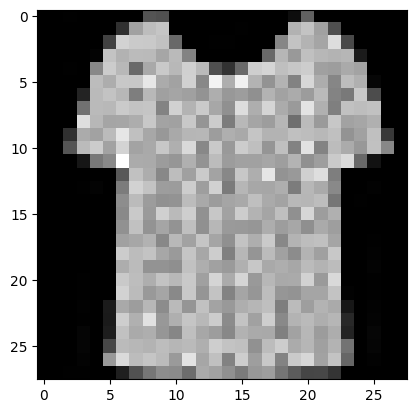

In [173]:
plt.imshow(fashionMNSIT_test_data.data[1000],cmap='gray')

In [174]:
class FashionMNISTModel(nn.Module):
     def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   
        )
        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,out_features=output_shape)
        )
     def forward(self,x):
        x = self.conv_block_1(x)
      #  print(f"The dims of x after Conv block 1 {x.shape}")
        x = self.conv_block_2(x)
      #  print(f"The dims of x after Conv block 2 {x.shape}")
        x = self.classifier(x)
      #  print(f"The dims of x after classifier block {x.shape}")
        return x

In [175]:
MODEL_PATH = 'models/Pytorch-Computer-Vision.pt'
# Hidden units is 40 because I train the original model with 40 hidden units
model_1 = FashionMNISTModel(input_shape=1,output_shape=len(fashionMNSIT_test_data.classes),hidden_units=40)
model_1.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu'),weights_only=False))
model_1.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 1.6606e-01,  2.8927e-01, -4.9044e-01],
                        [ 4.3421e-01,  2.8485e-02, -1.1488e-01],
                        [-4.5839e-01,  1.0656e-01,  3.7884e-01]]],
              
              
                      [[[-4.8883e-01,  3.0243e-01, -1.3411e-01],
                        [ 2.5365e-01,  3.4932e-01, -6.4854e-02],
                        [-1.8534e-01,  2.9074e-01, -2.3730e-01]]],
              
              
                      [[[-1.5561e-01,  8.4966e-02, -1.5358e-01],
                        [-3.9091e-02, -1.3539e-01,  2.2112e-01],
                        [-2.6312e-01, -1.5367e-01, -9.4125e-02]]],
              
              
                      [[[-1.5935e-01, -4.0729e-01, -6.4345e-01],
                        [ 6.3782e-01, -5.8606e-01,  3.7180e-01],
                        [ 4.0092e-01, -2.3686e-01,  4.9438e-01]]],
              
              
                      [[[-9.8463e-02,  1.7463e-01, -1

In [176]:
test_images, test_labels = fashionMNSIT_test_data.data,fashionMNSIT_test_data.classes

In [182]:
fashionMNSIT_test_dataloader = DataLoader(dataset=fashionMNSIT_test_data) 

In [198]:
y_whole_pred = []
model_1.eval()
with torch.inference_mode():
    for X,y in tqdm(fashionMNSIT_test_dataloader,desc="Making prediction"):
        # Send the data and target to target device
        y_logit = model_1(X)
        y_pred = torch.softmax(y_logit,dim=1).argmax(dim=1)
        # Put prediction to CPU for evaluations
        y_whole_pred.append(y_pred)

y_whole_pred = torch.cat(y_whole_pred)

Making prediction: 100%|██████████| 10000/10000 [00:36<00:00, 274.23it/s]


In [199]:
wrong_pred_indexes = np.where(test_preds != fashionMNSIT_test_data.targets)[0]
len(wrong_pred_indexes)

928

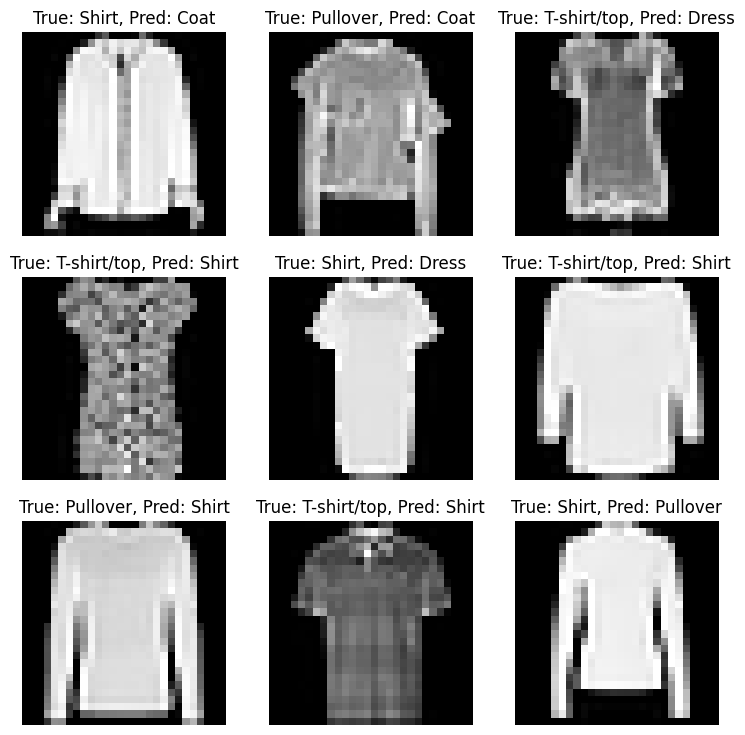

In [221]:
random_index = random.sample(list(wrong_pred_indexes),k=9)

plt.figure(figsize=(9,9))
for i,index in enumerate(random_index):
    true_label = fashionMNSIT_test_data.classes[fashionMNSIT_test_data[index][1]]
    pred_label = fashionMNSIT_test_data.classes[test_preds[index]]
    plt.subplot(3,3,i+1)
    plt.imshow(fashionMNSIT_test_data[index][0].squeeze(), cmap="gray")
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis(False)



While the model's performance can slightly improve, some of the data labels are very similar to each other, making it difficult to distinguish between them.